In [1]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [65]:
# Load the dataset from Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/Data/digit/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Data/digit/test.csv')

# Split training data into features and labels
X = train_data.iloc[:, 1:].values.astype('float32')  # All pixel values
y = train_data.iloc[:, 0].values.astype('int64')     # Labels (digits)

# Normalize the data (pixel values range from 0 to 255)
X = X / 255.0

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [12]:
#Create a custom dataset class
class MNISTDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]


In [67]:
# Create dataloaders for training and validation.
batch_size = 64

train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [68]:
# Define the CNN model.
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [69]:
#Initialize the model, loss function and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [70]:
# Train the model
# Define a function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

# Define the training loop
def train(model, device, train_loader, criterion, optimizer, epoch):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape to [batch_size, 1, 28, 28]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i + 1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0

    # Return average loss and accuracy for the epoch
    return running_loss / len(train_loader), running_acc / len(train_loader)

# Track training loss and accuracy
train_losses = []
train_accuracies = []


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    avg_loss, avg_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)

Epoch 1, Batch 200, Loss: 0.4696, Accuracy: 0.8525
Epoch 1, Batch 400, Loss: 0.1340, Accuracy: 0.9599
Epoch 2, Batch 200, Loss: 0.0708, Accuracy: 0.9772
Epoch 2, Batch 400, Loss: 0.0693, Accuracy: 0.9788
Epoch 3, Batch 200, Loss: 0.0443, Accuracy: 0.9868
Epoch 3, Batch 400, Loss: 0.0512, Accuracy: 0.9835
Epoch 4, Batch 200, Loss: 0.0364, Accuracy: 0.9885
Epoch 4, Batch 400, Loss: 0.0388, Accuracy: 0.9891
Epoch 5, Batch 200, Loss: 0.0253, Accuracy: 0.9916
Epoch 5, Batch 400, Loss: 0.0293, Accuracy: 0.9914
Epoch 6, Batch 200, Loss: 0.0190, Accuracy: 0.9941
Epoch 6, Batch 400, Loss: 0.0223, Accuracy: 0.9941
Epoch 7, Batch 200, Loss: 0.0153, Accuracy: 0.9954
Epoch 7, Batch 400, Loss: 0.0144, Accuracy: 0.9959
Epoch 8, Batch 200, Loss: 0.0148, Accuracy: 0.9951
Epoch 8, Batch 400, Loss: 0.0161, Accuracy: 0.9948
Epoch 9, Batch 200, Loss: 0.0123, Accuracy: 0.9963
Epoch 9, Batch 400, Loss: 0.0117, Accuracy: 0.9957
Epoch 10, Batch 200, Loss: 0.0075, Accuracy: 0.9977
Epoch 10, Batch 400, Loss: 0.0

In [109]:

# Define the test loop
def test(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape inputs to [batch_size, channels, height, width]
            inputs = inputs.view(-1, 1, 28, 28)  # MNIST images have a single channel (grayscale)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item()

            # Accumulate accuracy
            test_acc += accuracy(outputs, labels)

            # Store predictions and actual labels for further analysis if needed
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}')

    return all_preds, all_labels

# Test the model
all_preds, all_labels = test(model, device, test_loader, criterion)

Test Loss: 0.0412, Test Accuracy: 0.9910


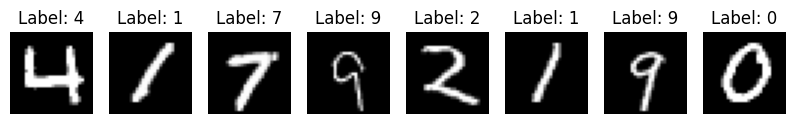

In [80]:
# Function to visualize some sample images
def visualize_samples(dataset, num_samples=5):
    # Set up the plot
    plt.figure(figsize=(10, 2))

    # Randomly select samples to visualize
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.view(28, 28).numpy()  # Reshape the image for visualization

        # Plot the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.show()

# Visualize samples from the training dataset
visualize_samples(train_dataset, num_samples=8)

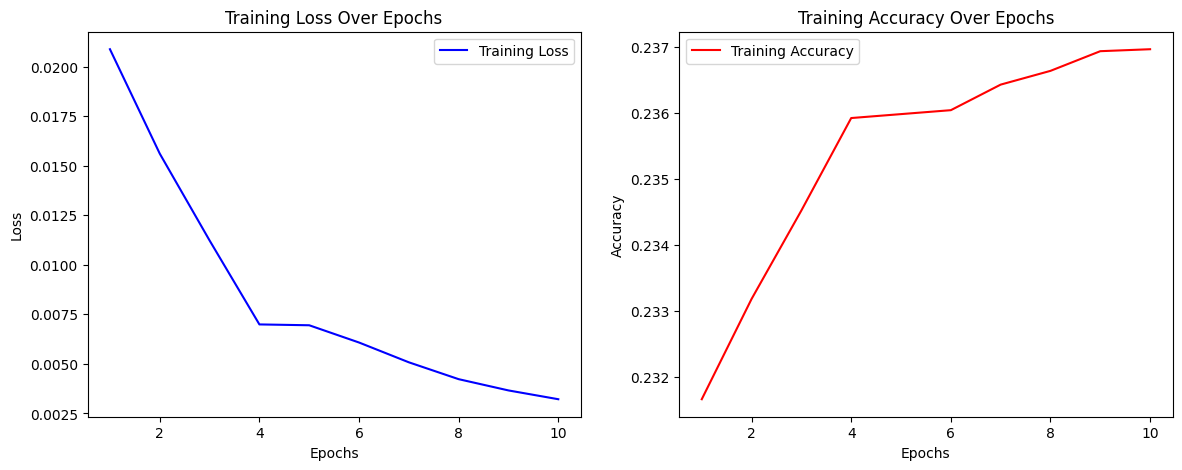

In [81]:
# train_losses and train_accuracies that store loss and accuracy after each epoch
def plot_training_progress(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot the training loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# After training, visualize the progress
plot_training_progress(train_losses, train_accuracies)

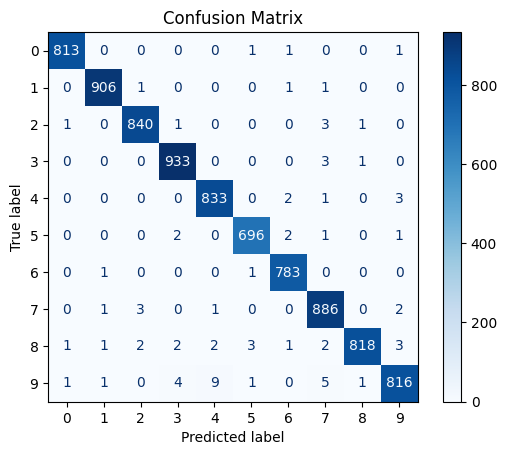

In [112]:
# Get confusion metrics to see module performing
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

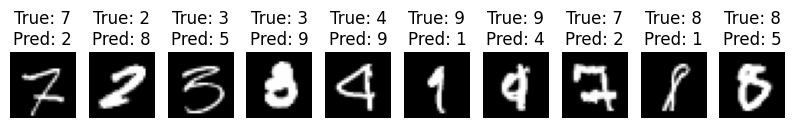

In [104]:
# display some examples where the model made incorrect predictions.
def visualize_incorrect_predictions(all_labels, all_preds, dataset, num_samples=10):
    incorrect_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]

    # Set up the plot
    plt.figure(figsize=(10, 2))

    # Randomly select incorrect predictions to visualize
    selected_indices = np.random.choice(incorrect_indices, num_samples, replace=False)

    for i, idx in enumerate(selected_indices):
        image, label = dataset[idx]
        image = image.view(28, 28).numpy()  # Reshape the image for visualization
        pred_label = all_preds[idx]

        # Plot the image with true and predicted labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {label}\nPred: {pred_label}')
        plt.axis('off')

    plt.show()

# Example usage (assuming `all_labels`, `all_preds`, and `test_dataset` are defined)
visualize_incorrect_predictions(all_labels, all_preds, test_dataset, num_samples=10)

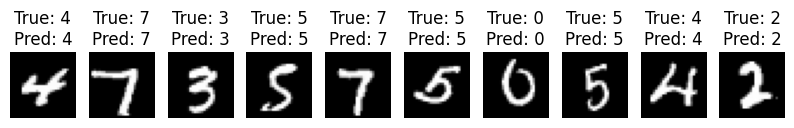

In [101]:
# display some examples where the model made correct predictions.
def visualize_correct_predictions(all_labels, all_preds, dataset, num_samples=10):
    correct_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true == pred]

    # Set up the plot
    plt.figure(figsize=(10, 2))

    # Randomly select correct predictions to visualize
    selected_indices = np.random.choice(correct_indices, num_samples, replace=True)

    for i, idx in enumerate(selected_indices):
        image, label = dataset[idx]
        image = image.view(28, 28).numpy()  # Reshape the image for visualization
        pred_label = all_preds[idx]

        # Plot the image with true and predicted labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {label}\nPred: {pred_label}')
        plt.axis('off')

    plt.show()

# Example usage (assuming `all_labels`, `all_preds`, and `test_dataset` are defined)
visualize_correct_predictions(all_labels, all_preds, test_dataset, num_samples=10)

In [105]:
# re-defining the model
# Define the CNN model with additional convolutional and fully connected layers
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # New convolutional layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # New convolutional layer

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = None
        self.fc2 = nn.Linear(512, 256)       # New fully connected layer
        self.fc3 = nn.Linear(256, 10)        ## Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))   # Forward pass through the new convolutional layer
        x = self.pool(F.relu(self.conv4(x)))   # Forward pass through the new convolutional layer

        # Calculate the input size for the fully connected layer dynamically
        if self.fc1 is None:
            # Flatten the tensor and calculate the correct input size for fc1
            num_features = x.size(1) * x.size(2) * x.size(3)
            self.fc1 = nn.Linear(num_features, 512).to(x.device)

        # Adjust the view according to the actual output size
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))                # Forward pass through the new fully connected layer
        x = self.fc3(x)                        # Output layer

        return x

# Create an instance of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
print(model)

dummy_input = torch.randn(1, 1, 28, 28).to(device)  # A single 28x28 input image
output = model(dummy_input)
print(output.shape)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([1, 10])


In [106]:
#Initialize the model, loss function and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [107]:
# Train the model
# Define a function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

# Define the training loop
def train(model, device, train_loader, criterion, optimizer, epoch):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape to [batch_size, 1, 28, 28]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i + 1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0

    # Return average loss and accuracy for the epoch
    return running_loss / len(train_loader), running_acc / len(train_loader)

# Track training loss and accuracy
train_losses = []
train_accuracies = []


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    avg_loss, avg_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)

Epoch 1, Batch 200, Loss: 0.6684, Accuracy: 0.7701
Epoch 1, Batch 400, Loss: 0.1359, Accuracy: 0.9573
Epoch 2, Batch 200, Loss: 0.0802, Accuracy: 0.9747
Epoch 2, Batch 400, Loss: 0.0832, Accuracy: 0.9730
Epoch 3, Batch 200, Loss: 0.0542, Accuracy: 0.9836
Epoch 3, Batch 400, Loss: 0.0524, Accuracy: 0.9840
Epoch 4, Batch 200, Loss: 0.0382, Accuracy: 0.9883
Epoch 4, Batch 400, Loss: 0.0425, Accuracy: 0.9866
Epoch 5, Batch 200, Loss: 0.0290, Accuracy: 0.9914
Epoch 5, Batch 400, Loss: 0.0280, Accuracy: 0.9916
Epoch 6, Batch 200, Loss: 0.0265, Accuracy: 0.9911
Epoch 6, Batch 400, Loss: 0.0338, Accuracy: 0.9897
Epoch 7, Batch 200, Loss: 0.0232, Accuracy: 0.9927
Epoch 7, Batch 400, Loss: 0.0191, Accuracy: 0.9935
Epoch 8, Batch 200, Loss: 0.0185, Accuracy: 0.9945
Epoch 8, Batch 400, Loss: 0.0180, Accuracy: 0.9934
Epoch 9, Batch 200, Loss: 0.0140, Accuracy: 0.9959
Epoch 9, Batch 400, Loss: 0.0151, Accuracy: 0.9944
Epoch 10, Batch 200, Loss: 0.0095, Accuracy: 0.9970
Epoch 10, Batch 400, Loss: 0.0

In [110]:
# Define the test loop
def test(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape inputs to [batch_size, channels, height, width]
            inputs = inputs.view(-1, 1, 28, 28)  # MNIST images have a single channel (grayscale)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item()

            # Accumulate accuracy
            test_acc += accuracy(outputs, labels)

            # Store predictions and actual labels for further analysis if needed
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}')

    return all_preds, all_labels

# Test the model
all_preds, all_labels = test(model, device, test_loader, criterion)

Test Loss: 0.0412, Test Accuracy: 0.9910


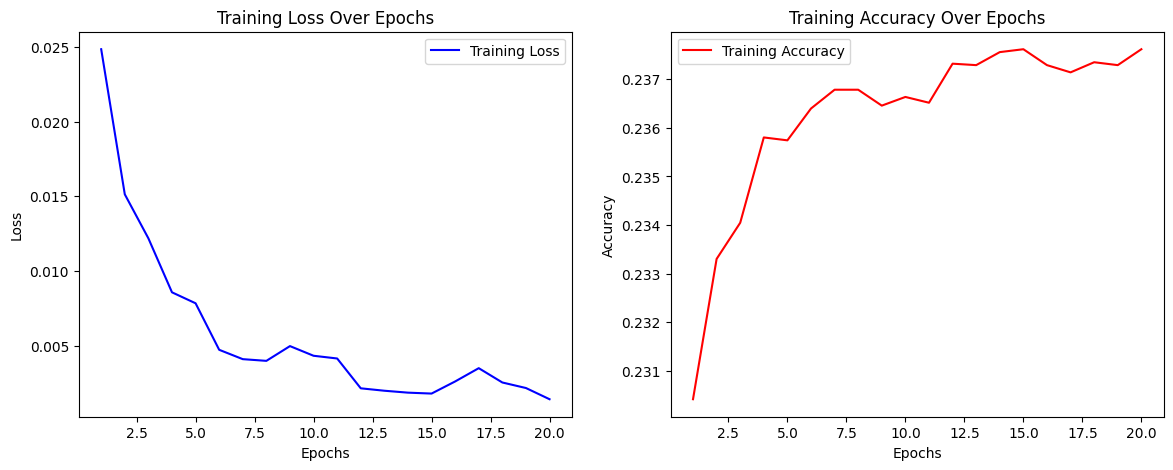

In [111]:
# train_losses and train_accuracies that store loss and accuracy after each epoch
def plot_training_progress(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot the training loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# After training, visualize the progress
plot_training_progress(train_losses, train_accuracies)

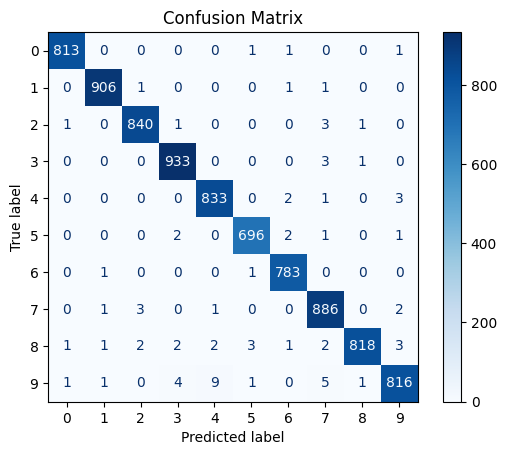

In [113]:
# Get confusion metrics to see module performing
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()